# Area Coverage

This tutorial demonstrates how to model sensor geometries, obtain the nadir sensor projections on the Earth's surface and compute intersections to cover a polygonal area of interest

## Setup

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

from ostk.mathematics.geometry.d2.object import Point as Point2d
from ostk.mathematics.geometry.d2.object import LineString as LineString2d
from ostk.mathematics.geometry.d2.object import Polygon as Polygon2d
from ostk.mathematics.geometry.d3.object import Point as Point3d
from ostk.mathematics.geometry.d3.object import Polygon as Polygon3d
from ostk.mathematics.geometry.d3.object import Pyramid
from ostk.mathematics.geometry.d3.object import Cone
from ostk.mathematics.geometry import Angle as MathAngle

from ostk.physics import Environment
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate import Frame
from ostk.physics.environment.object import Geometry

from ostk.astrodynamics.flight import Profile
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.model import SGP4
from ostk.astrodynamics.trajectory.orbit.model.sgp4 import TLE

---

## Computation

### Environment

We first set up a simple scene, with the Earth only (the default `Environment` will suffice here):

In [2]:
environment = Environment.default()

Then, we access the `Earth` object (managed by the `Environment`):

In [3]:
earth = environment.access_celestial_object_with_name("Earth")

Once the `Earth` has been obtained, we can also get its geometry (an `Ellipsoid`, defined in `ITRF` in this case):

In [4]:
earth_geometry = earth.get_geometry_in(Frame.ITRF(), environment.get_instant())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using a TLE.

In [5]:
tle = TLE(
    "1 39419U 13066D   18260.77424112  .00000022  00000-0  72885-5 0  9996",
    "2 39419  97.6300 326.6556 0013847 175.2842 184.8495 14.93888428262811",
)

In [6]:
sgp4_model = SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [7]:
satellite_orbit = Orbit(sgp4_model, earth)

In [8]:
start_instant = tle.get_epoch() + Duration.hours(7.0)
end_instant = start_instant + Duration.hours(2.0)

interval = Interval.closed(start_instant, end_instant)

We select an arbitrary step duration, convenient for the following display

In [9]:
step = Duration.seconds(100.0)

In [10]:
instants = interval.generate_grid(step)

In [11]:
states = [satellite_orbit.get_state_at(instant) for instant in instants]

In [12]:
states_lla = [
    LLA.cartesian(
        state.in_frame(Frame.ITRF()).get_position().get_coordinates(),
        earth.get_equatorial_radius(),
        earth.get_flattening(),
    )
    for state in states
]

In [13]:
states_line_string = LineString2d(
    [
        Point2d(
            state_lla.get_longitude().in_degrees(),
            state_lla.get_latitude().in_degrees(),
        )
        for state_lla in states_lla
    ]
)

In [14]:
ground_track_df = pd.DataFrame(
    [
        [
            float(state_lla.get_longitude().in_degrees()),
            float(state_lla.get_latitude().in_degrees()),
        ]
        for state_lla in states_lla
    ],
    columns=["Longitude", "Latitude"],
)

In [15]:
ground_track_df.head()

,Longitude,Latitude
0,136.034956,51.823146
1,133.713040,45.712846
2,131.766690,39.568577
3,130.068975,33.399310
4,128.540593,27.211162


## Area Target

Let's define a target `Polygon2d` (Longitude, Latitude) representing an area of interest (covering part of Europe):

In [16]:
target_coordinates = [
    [8.26171875, 53.64463782485651],
    [5.625, 53.225768435790194],
    [5.09765625, 52.3755991766591],
    [3.33984375, 51.17934297928927],
    [1.7578125, 50.736455137010665],
    [0.3515625, 49.38237278700955],
    [-0.87890625, 49.26780455063753],
    [-4.5703125, 48.3416461723746],
    [-0.52734375, 46.437856895024204],
    [-1.23046875, 44.465151013519616],
    [-1.9335937499999998, 43.197167282501276],
    [3.33984375, 42.4234565179383],
    [3.33984375, 43.58039085560784],
    [6.328125, 42.94033923363181],
    [7.55859375, 43.70759350405294],
    [10.1953125, 44.08758502824516],
    [11.6015625, 42.032974332441405],
    [14.765625, 40.58058466412761],
    [15.99609375, 37.996162679728116],
    [18.28125, 40.17887331434696],
    [11.953125, 44.33956524809713],
    [13.18359375, 45.9511496866914],
    [17.578125, 42.94033923363181],
    [22.32421875, 37.020098201368114],
    [23.203125, 40.44694705960048],
    [25.839843749999996, 40.44694705960048],
    [27.24609375, 41.11246878918088],
    [28.30078125, 43.32517767999296],
    [30.234375, 46.92025531537451],
    [35.68359375, 46.6795944656402],
    [38.3203125, 47.27922900257082],
    [39.90234375, 49.61070993807422],
    [35.859375, 50.84757295365389],
    [33.92578125, 52.3755991766591],
    [31.9921875, 52.26815737376817],
    [31.46484375, 53.85252660044951],
    [30.234375, 55.87531083569679],
    [28.30078125, 56.17002298293205],
    [27.59765625, 59.085738569819505],
    [24.78515625, 59.17592824927136],
    [22.67578125, 59.17592824927136],
    [24.08203125, 57.98480801923985],
    [24.2578125, 57.231502991478926],
    [22.148437499999996, 57.70414723434193],
    [21.26953125, 57.136239319177434],
    [21.09375, 55.87531083569679],
    [20.214843749999996, 54.57206165565852],
    [17.75390625, 54.87660665410869],
    [14.94140625, 53.9560855309879],
    [12.65625, 54.36775852406841],
    [10.1953125, 54.36775852406841],
    [10.01953125, 57.231502991478926],
    [8.0859375, 57.136239319177434],
    [8.26171875, 53.64463782485651],
]

or the continental US for instance:

In [17]:
target_coordinates = [
    [-124.541015625, 48.28319289548349],
    [-123.837890625, 44.902577996288876],
    [-124.45312499999999, 42.61779143282346],
    [-124.365234375, 40.38002840251183],
    [-121.11328124999999, 35.02999636902566],
    [-118.037109375, 33.94335994657882],
    [-117.24609374999999, 32.54681317351514],
    [-114.43359375, 32.84267363195431],
    [-111.005859375, 31.353636941500987],
    [-108.6328125, 31.203404950917395],
    [-108.28125, 32.02670629333614],
    [-106.5234375, 31.57853542647338],
    [-103.095703125, 28.76765910569123],
    [-102.3046875, 29.6880527498568],
    [-101.162109375, 29.6880527498568],
    [-97.646484375, 25.799891182088334],
    [-96.6796875, 28.76765910569123],
    [-94.482421875, 29.611670115197377],
    [-92.900390625, 29.84064389983441],
    [-90.087890625, 29.305561325527698],
    [-90, 30.14512718337613],
    [-88.06640625, 30.44867367928756],
    [-85.69335937499999, 30.29701788337205],
    [-84.90234375, 29.6880527498568],
    [-84.287109375, 30.14512718337613],
    [-82.96875, 29.305561325527698],
    [-80.947265625, 25.085598897064752],
    [-80.244140625, 25.48295117535531],
    [-81.474609375, 30.826780904779774],
    [-76.11328125, 35.67514743608467],
    [-73.564453125, 40.84706035607122],
    [-70.3125, 41.64007838467894],
    [-70.3125, 43.197167282501276],
    [-65.21484375, 45.583289756006316],
    [-68.5546875, 47.517200697839414],
    [-70.57617187499999, 45.460130637921004],
    [-74.70703125, 44.84029065139799],
    [-76.904296875, 43.51668853502906],
    [-79.189453125, 43.197167282501276],
    [-81.650390625, 41.83682786072714],
    [-83.408203125, 41.902277040963696],
    [-81.73828125, 44.402391829093915],
    [-83.232421875, 46.01222384063236],
    [-88.154296875, 48.28319289548349],
    [-90.87890625, 48.22467264956519],
    [-94.833984375, 49.095452162534826],
    [-123.3984375, 49.095452162534826],
    [-124.541015625, 48.28319289548349],
]

We create the `Polygon2d` using those coordinates

In [18]:
target_geometry = Polygon2d(
    [
        Point2d(float(point_coordinates[0]), float(point_coordinates[1]))
        for point_coordinates in target_coordinates
    ]
)

### Sensor

We define our orbital frame:

In [19]:
orbital_profile = Profile.local_orbital_frame_pointing(satellite_orbit, Orbit.FrameType.VVLH)
if Frame.exists("Body"):
    Frame.destruct("Body")

body_frame = orbital_profile.get_body_frame("Body")

In [20]:
def calculate_intersection(state, sensor_geometry):
    observer_geometry_ITRF = sensor_geometry.in_frame(Frame.ITRF(), state.get_instant())

    intersection_ITRF = observer_geometry_ITRF.intersection_with(earth_geometry)

    if not intersection_ITRF.is_defined():
        return None

    intersection_points = [
        Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees())
        for lla in [
            LLA.cartesian(
                point_ITRF.as_vector(),
                earth.get_equatorial_radius(),
                earth.get_flattening(),
            )
            for point_ITRF in intersection_ITRF.access_composite()
            .access_object_at(0)
            .as_line_string()
        ]
    ]

    if len(intersection_points) < 3:
        return None

    return intersection_ITRF

Let's define a pyramidal geometry:

In [21]:
apex_B = Point3d(0.0, 0.0, 0.0)
base_B = Polygon3d(
    Polygon2d(
        [
            Point2d(-0.5, -0.5),
            Point2d(+0.5, -0.5),
            Point2d(+0.5, +0.5),
            Point2d(-0.5, +0.5),
        ]
    ),
    apex_B + np.array((0.0, 0.0, 1.0)),
    np.array((1.0, 0.0, 0.0)),
    np.array((0.0, 1.0, 0.0)),
)

pyramid_B = Pyramid(base_B, apex_B)

We could also use a conical geometry:

In [22]:
cone_B = Cone(apex_B, np.array((0.0, 0.0, 1.0)), MathAngle.degrees(30.0))

The satellite body frame and the geometry allow us to define a complete sensor geometry

In [23]:
sensor_geometry = Geometry(cone_B, body_frame)

Assuming nadir pointing over the full course of the orbit, we obtain the intersections between the sensor geometry and the Earth's surface for all instants

In [24]:
intersections_ITRF = [
    calculate_intersection(state, sensor_geometry) for state in states
]

In [25]:
intersections_ITRF = [
    intersection_ITRF
    for intersection_ITRF in intersections_ITRF
    if intersection_ITRF is not None
]

In [26]:
intersections_LLs = [
    [
        Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees())
        for lla in [
            LLA.cartesian(
                point_ITRF.as_vector(),
                earth.get_equatorial_radius(),
                earth.get_flattening(),
            )
            for point_ITRF in intersection_ITRF.access_composite()
            .access_object_at(0)
            .as_line_string()
        ]
    ]
    for intersection_ITRF in intersections_ITRF
]

Those intersections represent the nadir sensor projections, that we store in a list of pandas dataframes

In [27]:
intersection_dfs = [
    pd.DataFrame(
        [
            [float(intersection_point.x()), float(intersection_point.y())]
            for intersection_point in intersection_LLs
        ],
        columns=["Longitude", "Latitude"],
    )
    for intersection_LLs in intersections_LLs
]

In [28]:
intersection_dfs[0].head()

,Longitude,Latitude
0,131.975198,53.728725
1,132.510489,54.098650
2,133.146955,54.411556
3,133.868306,54.658299
4,134.654552,54.831501


---

### Target Intersection

We first construct the `Polygon2d` representing the Sensor projections computed above

In [29]:
intersections_polygons_2d = [
    Polygon2d(coordinates) for coordinates in intersections_LLs
]

Let's compute the intersection regions between the Sensor projections and the area of interest (our target). The output of this operations will be a set of Geometries (mainly `Polygon2d` as well) representing the portions of the area of interest covered by our sensor (assuming nadir pointing)

In [30]:
intersections_with_target_polygons = [
    sensor_projection.intersection_with(target_geometry)
    if sensor_projection.intersects(target_geometry)
    else None
    for sensor_projection in intersections_polygons_2d
]

Let's convert those intersection geometries in Longitude, Latitude coordinates

In [31]:
intersections_with_target_lls = []

for target_intersection in intersections_with_target_polygons:
    if target_intersection:
        composite = target_intersection.access_composite()

        object_count = composite.get_object_count()

        polygons_lls = []

        for i in range(object_count):
            polygon = composite.access_object_at(i)

            intersections_with_target_lls.append(polygon.get_vertices())

Finally we create the dataframe to store those intersections

In [32]:
target_intersection_dfs = [
    pd.DataFrame(
        [
            [float(intersection_point.x()), float(intersection_point.y())]
            for intersection_point in intersection_LLs
        ],
        columns=["Longitude", "Latitude"],
    )
    for intersection_LLs in intersections_with_target_lls
]

## Visualization

2D plot:

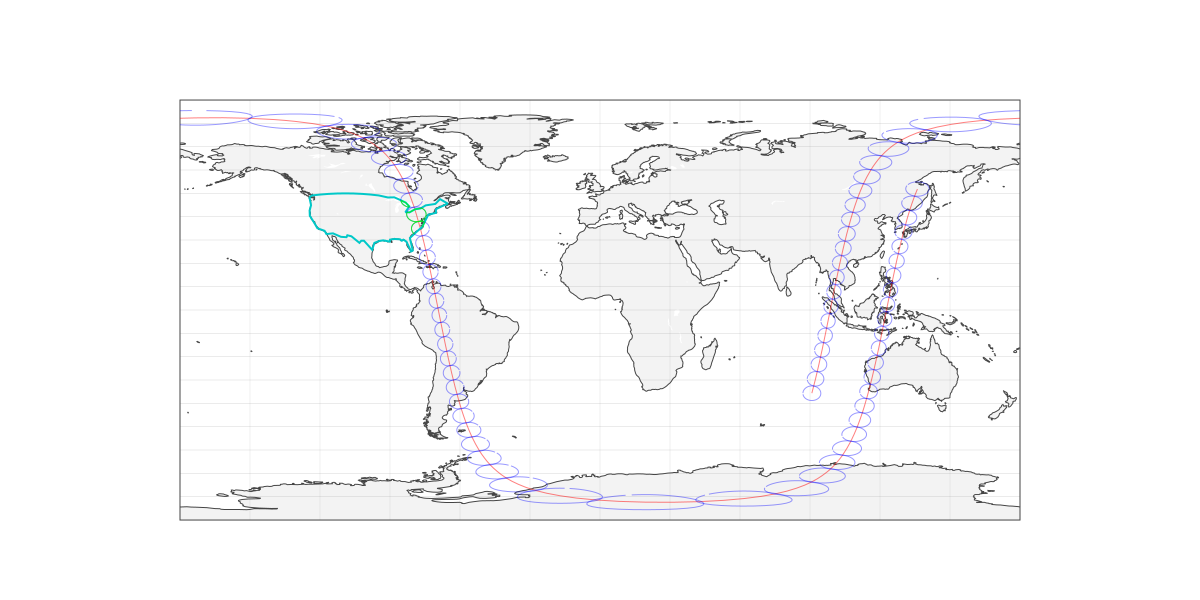

In [33]:
data = []

# Satellite Ground Track

data.append(
    go.Scattergeo(
        lon=ground_track_df["Longitude"],
        lat=ground_track_df["Latitude"],
        mode="lines",
        line=dict(
            width=1,
            color="rgba(255, 0, 0, 0.5)",
        ),
    )
)

# Area Target Geometry

data.append(
    go.Scattergeo(
        lon=[coordinate[0] for coordinate in target_coordinates],
        lat=[coordinate[1] for coordinate in target_coordinates],
        mode="lines",
        line=dict(
            width=2,
            color="rgba(0, 200, 200, 1.0)",
        ),
    )
)

# Satellite Sensor Projections

for intersection_df in intersection_dfs:
    data.append(
        go.Scattergeo(
            lon=intersection_df["Longitude"],
            lat=intersection_df["Latitude"],
            mode="lines",
            line=dict(
                width=1,
                color="rgba(0, 0, 255, 0.4)",
            ),
        )
    )

# Satellite Sensor Projections Intersection with Area of Interest

for intersection_df in target_intersection_dfs:
    data.append(
        go.Scattergeo(
            lon=intersection_df["Longitude"],
            lat=intersection_df["Latitude"],
            mode="lines",
            line=dict(
                width=1,
                color="rgba(0, 255, 0, 0.8)",
            ),
        )
    )

figure = go.Figure(
    data=data,
    layout=go.Layout(
        title=None,
        showlegend=False,
        height=600,
        width=1200,
        geo=go.layout.Geo(
            showland=True,
            landcolor="rgb(243, 243, 243)",
            countrycolor="rgb(204, 204, 204)",
            lonaxis=dict(showgrid=True, gridcolor="rgb(102, 102, 102)", gridwidth=0.1),
            lataxis=dict(showgrid=True, gridcolor="rgb(102, 102, 102)", gridwidth=0.1),
        ),
    ),
)

figure.show("svg")

3D plot:

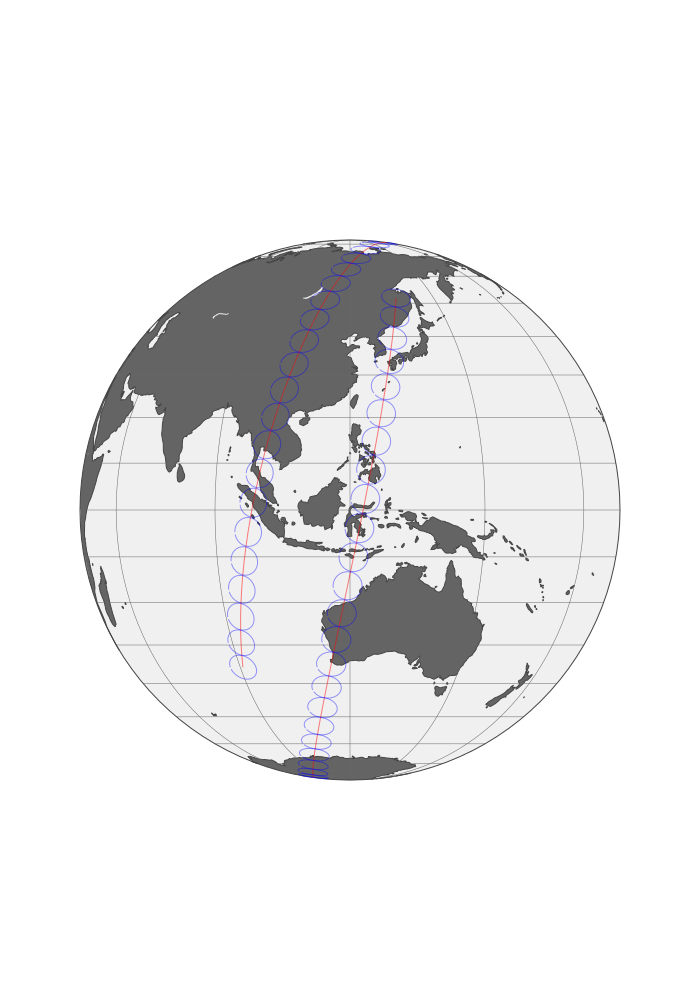

In [34]:
data = []

# Satellite Ground Track

data.append(
    go.Scattergeo(
        lon=ground_track_df["Longitude"],
        lat=ground_track_df["Latitude"],
        mode="lines",
        line=dict(
            width=1,
            color="rgba(255, 0, 0, 0.5)",
        ),
    )
)

# Area Target Geometry

data.append(
    go.Scattergeo(
        lon=[coordinate[0] for coordinate in target_coordinates],
        lat=[coordinate[1] for coordinate in target_coordinates],
        mode="lines",
        line=dict(
            width=2,
            color="rgba(0, 200, 200, 1.0)",
        ),
    )
)

# Satellite Sensor Projections

for intersection_df in intersection_dfs:
    data.append(
        go.Scattergeo(
            lon=intersection_df["Longitude"],
            lat=intersection_df["Latitude"],
            mode="lines",
            line=dict(
                width=1,
                color="rgba(0, 0, 255, 0.4)",
            ),
        )
    )

# Satellite Sensor Projections Intersection with Area of Interest

for intersection_df in target_intersection_dfs:
    data.append(
        go.Scattergeo(
            lon=intersection_df["Longitude"],
            lat=intersection_df["Latitude"],
            mode="lines",
            line=dict(
                width=1,
                color="rgba(0, 255, 0, 0.6)",
            ),
        )
    )

figure = go.Figure(
    data=data,
    layout=go.Layout(
        title=None,
        showlegend=False,
        height=1000,
        geo=go.layout.Geo(
            showland=True,
            showlakes=True,
            showcountries=False,
            showocean=True,
            countrywidth=0.0,
            landcolor="rgb(100, 100, 100)",
            lakecolor="rgb(240, 240, 240)",
            oceancolor="rgb(240, 240, 240)",
            projection=dict(type="orthographic", rotation=dict(lon=120, lat=0, roll=0)),
            lonaxis=dict(showgrid=True, gridcolor="rgb(102, 102, 102)", gridwidth=0.5),
            lataxis=dict(showgrid=True, gridcolor="rgb(102, 102, 102)", gridwidth=0.5),
        ),
    ),
)

figure.show("svg")

---